In [1]:
import pandas as pd
import ujson as json

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Read Data

We run into memory issues using the code block below:

```python
data = pd.read_json('../data/17.04_association_data.json',
                    orient='records',
                    typ='frame',
                    lines=True,
                    numpy=True)
```

Thus, I have turned to another library to iteratively load the JSON file into memory.

In [2]:
# Convert the JSON data to a list of strings. I can then parse the strings
# using usjon later.
filename = '../data/17.04_association_data.json'
with open(filename, 'r+') as f:
    data = f.readlines()
data = [x.rstrip() for x in data]

In [3]:
len(data)

2673321

In [4]:
from pprint import pprint
pprint(json.loads(data[0]))

{'association_score': {'datasources': {'cancer_gene_census': 0.90830650599492,
                                       'chembl': 0.825695006743774,
                                       'europepmc': 0.30565916633482804,
                                       'eva': 0.905780555555555,
                                       'eva_somatic': 0.0,
                                       'expression_atlas': 0.190300397794741,
                                       'gene2phenotype': 1.0,
                                       'gwas_catalog': 0.0,
                                       'intogen': 0.0,
                                       'phenodigm': 0.14626161111111102,
                                       'reactome': 1,
                                       'uniprot': 1,
                                       'uniprot_literature': 1},
                       'datatypes': {'affected_pathway': 1.0,
                                     'animal_model': 0.14626161111111102,
                    

From observation, I'm seeing that the `datatypes` key-value dictionary under the `association_score` data dictionary looks like the thing that is used for data analysis. On the other hand, there's an `evidence_count` thing as well - I think that one is the so-called "raw data". What was used in the paper should be the `association_score -> datatypes` dictionary.



In [20]:
from tqdm import tqdm
records = []
for d in tqdm(data):
    # Get the datatype out.
    d = json.loads(d)
    record = d['association_score']['datatypes']
    # Add the target symbol to the record.
    record['target'] = d['target']['gene_info']['symbol']
    record['target_id'] = d['target']['id']
    # Add the disease ID to the record.
    record['disease'] = d['disease']['id']
    record['disease_efo_label'] = d['disease']['efo_info']['label']
    records.append(record)

100%|██████████| 2673321/2673321 [00:49<00:00, 54494.14it/s]


Let's write this to the "feather" format - it'll let us load the dataframe really quickly in other notebooks.

In [21]:
pd.DataFrame(records).to_feather('../data/association_score_data_types.feather')

Just to test, let's reload the dataframe.

In [22]:
df = pd.read_feather('../data/association_score_data_types.feather')

In [23]:
df.head()

,affected_pathway,animal_model,disease,disease_efo_label,genetic_association,known_drug,literature,rna_expression,somatic_mutation,target,target_id
0,1.0,0.146262,EFO_0000616,neoplasm,1.0,0.825695,0.305659,0.190300,0.908307,PIK3CA,ENSG00000121879
1,1.0,0.000000,EFO_0000616,neoplasm,1.0,1.000000,0.260070,0.225325,0.903195,PDGFRB,ENSG00000113721
2,0.0,0.250456,EFO_0000616,neoplasm,1.0,1.000000,0.289234,0.337070,0.905496,RET,ENSG00000165731
3,1.0,0.307244,EFO_0000616,neoplasm,1.0,0.000000,0.323856,0.147515,0.907845,PTEN,ENSG00000171862
4,1.0,0.286196,EFO_0000508,genetic disorder,1.0,0.937995,0.088300,0.000000,0.000000,FGFR3,ENSG00000068078


Great! Sanity check passed :).

# Exploratory Analysis

Let's go on to some exploratory analysis of the data.

I'd like to first see how many of each target type is represented in the dataset.

In the paper, for each target, the GSK research group used a simple "mean" of all evidence strengths across all diseases for a given target. I wasn't very satisfied with this, as I'm concerned about variability across diseases. Thus, to start, I will begin with a "coefficient of variation" computation, which will give us a good measure of the spread relative to the mean.

If the spread (measured by standard deviation) is greater than the mean, we should see CV > 1. Intuitively, I think this may indicate problems with using a simple mean.

To ensure that we don't get any `NaN` values after the computation, I will replace all zero-valued data with an infinitesimally small number, $ 10^{-6} $.

In [24]:
df_cv = df.replace(0, 1E-6).groupby('target').std() / df.replace(0, 1E-6).groupby('target').mean()
df_cv.sample(10)

,affected_pathway,animal_model,genetic_association,known_drug,literature,rna_expression,somatic_mutation
target,,,,,,,
SMAD3,18.634848,2.071237,3.431977,0.0,1.166608,3.452196,3.466269
SOWAHA,0.000000,0.000000,0.000000,0.0,3.180584,1.006704,0.000000
NECTIN1,0.000000,1.999776,2.143729,0.0,1.141676,2.506100,0.000000
RPS6KC1,0.000000,0.000000,2.592746,0.0,3.827168,0.747198,0.000000
KRT6C,0.000000,2.929424,1.726282,0.0,1.000118,1.445214,0.000000
RN7SL655P,0.000000,0.000000,0.000000,0.0,0.000000,0.308408,0.000000
GOLGA2,3.237703,0.000000,0.000000,0.0,0.753587,2.021933,0.000000
DIP2B,0.000000,0.000000,2.120124,0.0,2.194691,1.104664,0.000000
CDKN2AIPNL,0.000000,0.000000,0.000000,0.0,0.000000,0.550598,0.000000


How many target-disease pairs represented?

In [25]:
len(df)

2673321

How many unique targets are there?

In [26]:
len(df_cv)

31051

And how many unique diseases are represented?

In [27]:
len(df.groupby('disease').mean())

8891

In [28]:
# Theoretical number of target-disease pairs
len(df_cv) * len(df.groupby('disease').mean())

276074441

If densely populated, there should be $ 31051 \times 8891 \approx 270 million $ unique combinations. However, we only have $ 2673321 \approx 2.6 million $ target-disease pairs represented. That means a very sparse dataset.

Let's now do a simple count of the cells here:

- How many have non-zero values?
- Of those that have non-zero values:
    - How many have CV < 1?
    - How many have CV = 1?
    - How many have CV > 1?

In [29]:
# This is the number of cells that have nonzero values.
df_cv[df_cv != 0].isnull()

,affected_pathway,animal_model,genetic_association,known_drug,literature,rna_expression,somatic_mutation
target,,,,,,,
7SK,True,True,True,True,True,False,True
A1BG,True,True,True,True,False,False,True
A1BG-AS1,True,True,True,True,True,False,True
A1CF,True,True,False,True,False,False,True
A2M,True,True,True,True,False,False,True
A2M-AS1,True,True,True,True,True,False,True
A2ML1,True,True,False,True,False,False,True
A2ML1-AS2,True,True,True,True,True,True,True
A3GALT2,True,True,True,True,False,False,True


In [30]:
import matplotlib.pyplot as plt
import numpy as np
def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    return x, y

Let's make an ECDF scatter plot of the non-zero data. We're still only interested in the coefficient of variation (CV). In the following plots, I will plot the ECDF of log10-transformed CV scores for each target. Recall that CV < 1 means that variation is less than the mean; CV approx. 1 indicates variation close to magnitude of mean, and CV > 1 indicates variation greater than mean. I would like to see what proportion of CV scores are greater than 1.

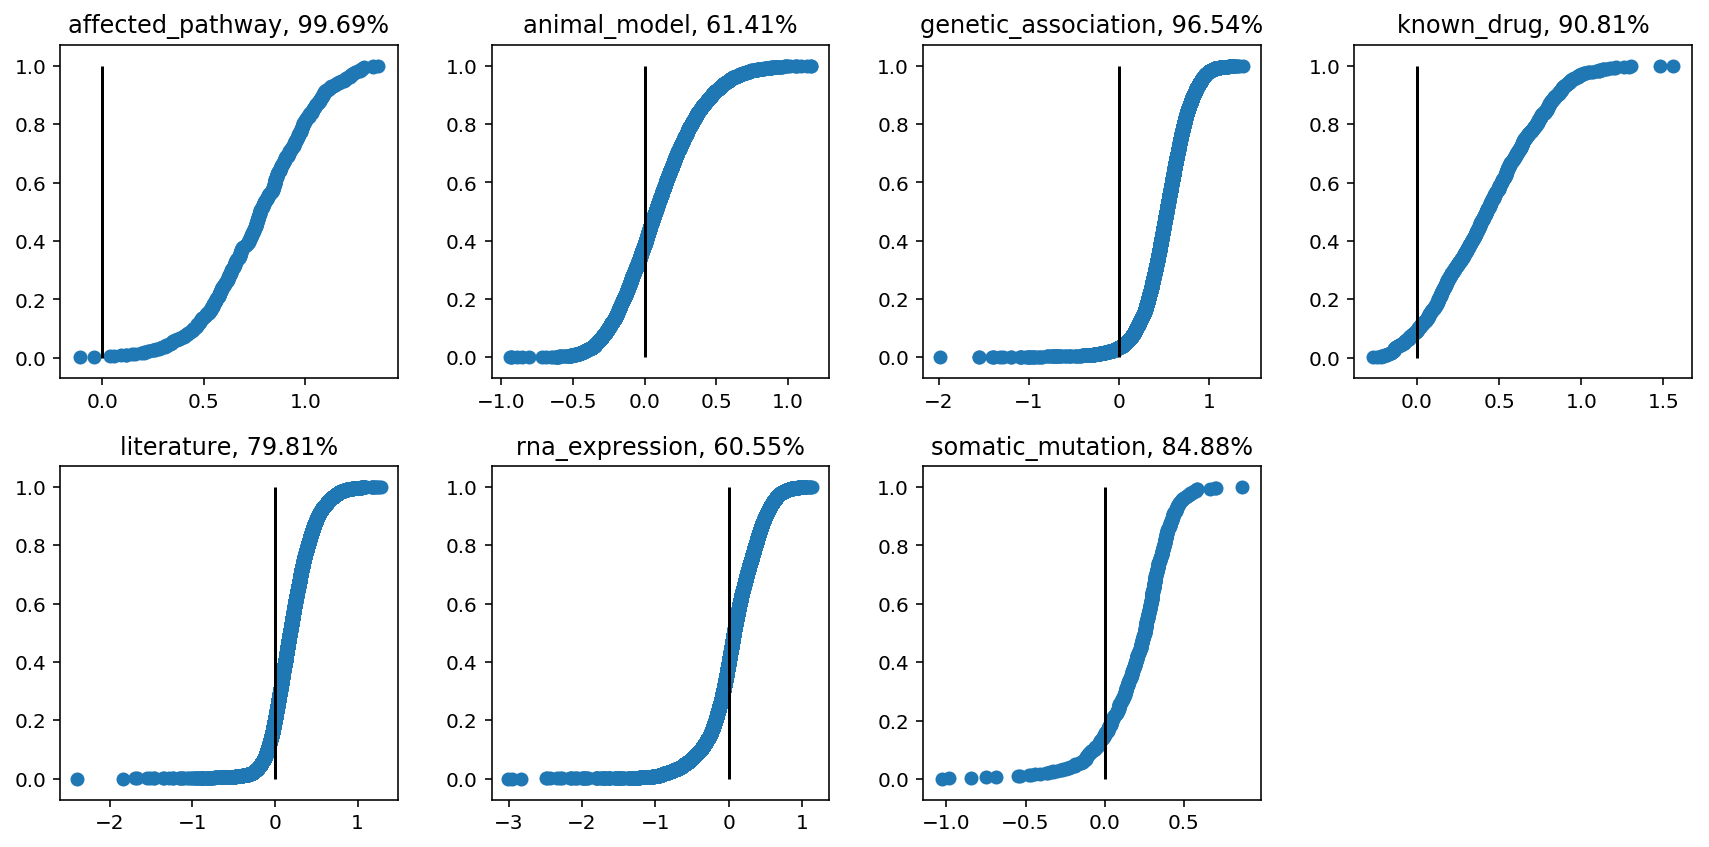

In [31]:
from matplotlib.gridspec import GridSpec
from scipy.stats import percentileofscore as pos

df_cv_nonzero = df_cv[df_cv != 0]

gs = GridSpec(2, 4)
fig = plt.figure(figsize=(12, 6))

for i, col in enumerate(df_cv.columns):
    x, y = ecdf(df_cv_nonzero[col].dropna())
    x = np.log10(x)
    ax = fig.add_subplot(gs[i])
    ax.scatter(x, y)
    
    # What percentile is the value 0
    zero_pos = pos(x, 0)
    ax.set_title(f'{col}, {100 - np.round(zero_pos, 2)}%')
    ax.vlines(x=0, ymin=0, ymax=1)
plt.tight_layout()
plt.show()

**Figure:** Distribution of log10-transformed CV scores for each variable of interest in the dataset. Vertical line at zero indicates $log10(CV) = 0$, which means $CV = 1$. Percentage of datapoints with CV > 1 is indicated in each subplot's title.

Comment: I'm not surprised, then, that the animal model and RNA expression scores were most predictive...

In the next notebook, I will explore whether I can reproduce the 